In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
csv_path = "/content/drive/MyDrive/autoenc.csv"
df = pd.read_csv("/content/drive/MyDrive/autoenc.csv", header=None)

X_autoenc = df.iloc[:, :8].values
X_autoenc = X_autoenc.astype(float)
print("Autoencoder shape:", X_autoenc.shape)

Autoencoder shape: (98664, 8)


In [4]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 118.5 MB/s eta 0:00:00


# Angle Encoding with 8 Qubits

In [5]:
import pennylane as qml

# Define number of qubits
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit for angle encoding
@qml.qnode(dev)
def angle_encode(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    return qml.state()

# Normalize features to [0, pi]
X_auto_norm = (X_autoenc - np.min(X_autoenc, axis=0)) / (np.max(X_autoenc, axis=0) - np.min(X_autoenc, axis=0))
X_auto_angles = X_auto_norm * np.pi

# Encode the first N samples
encoded_states = []
N = 98664
for i in range(N):
    state = angle_encode(X_auto_angles[i])
    encoded_states.append(state)

encoded_states = np.array(encoded_states)
print("Encoded quantum states shape:", encoded_states.shape)


Encoded quantum states shape: (98664, 256)


In [6]:
quantum_real = np.real(encoded_states)
quantum_imag = np.imag(encoded_states)

# Stack real and imaginary parts
quantum_full = np.hstack([quantum_real, quantum_imag])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


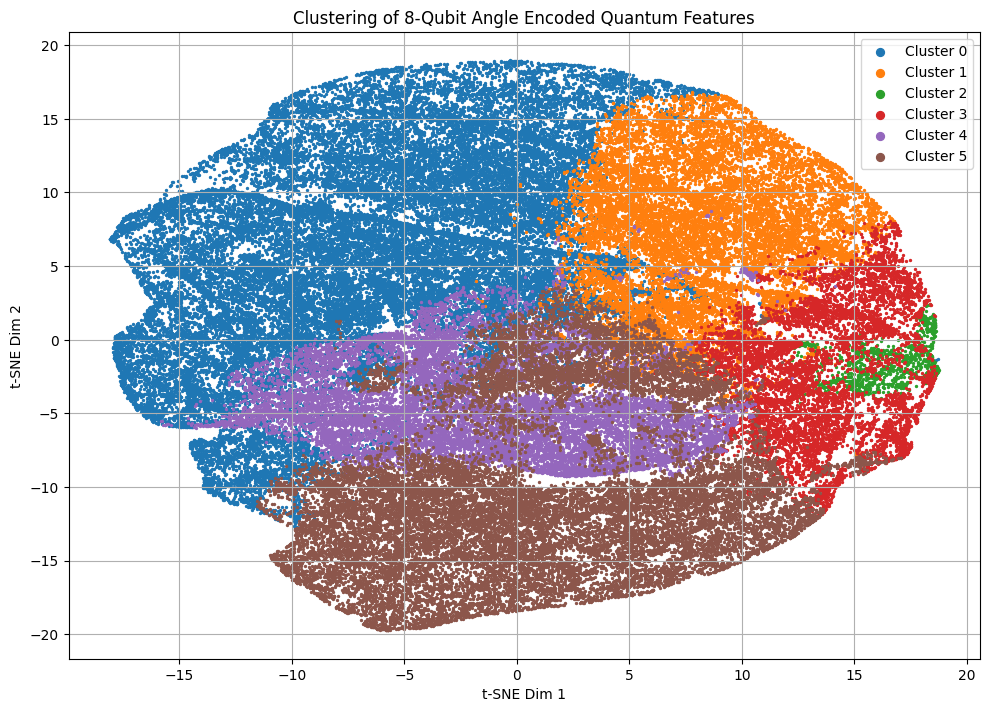

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(quantum_full)

# KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(X_scaled)

# t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0, n_iter=500)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE with cluster labels
plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = X_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)
plt.grid(True)
plt.tight_layout()
plt.title("Clustering of 8-Qubit Angle Encoded Quantum Features")
plt.show()

In [8]:
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score (8-Qubit Angle Encoded Features, KMeans): {score:.4f}")

Silhouette Score (8-Qubit Angle Encoded Features, KMeans): 0.2066


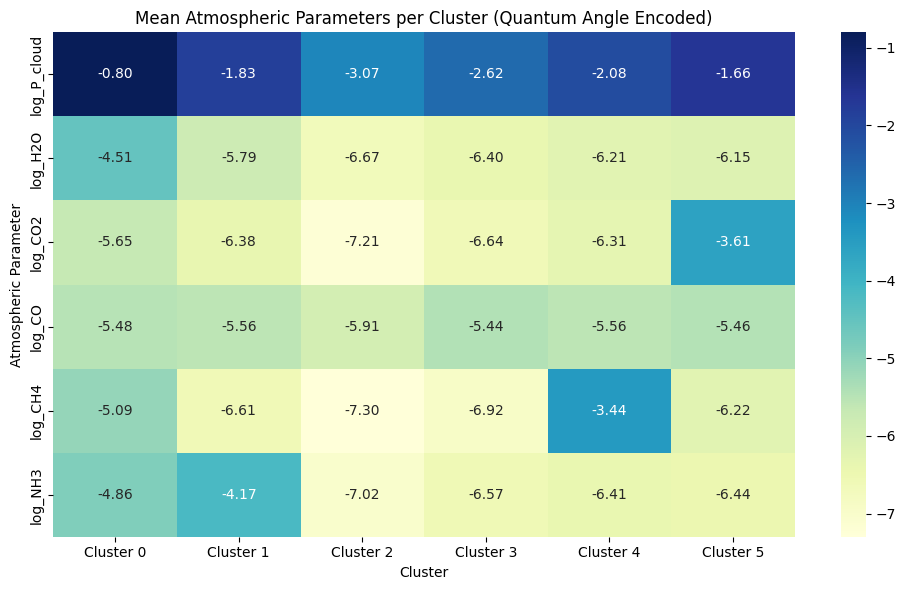

In [ ]:
selected_params = ['log_P_cloud', 'log_H2O', 'log_CO2',
                   'log_CO', 'log_CH4', 'log_NH3']

# Extract atmospheric parameters
params = df.iloc[:, 8:14].values.astype(float)
params_df = pd.DataFrame(params, columns=selected_params)

params_df['cluster'] = labels

cluster_means = params_df.groupby('cluster')[selected_params].mean()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=[f'Cluster {i}' for i in cluster_means.index],
            yticklabels=selected_params)

plt.title("Mean Atmospheric Parameters per Cluster (Quantum Angle Encoded)")
plt.xlabel("Cluster")
plt.ylabel("Atmospheric Parameter")
plt.tight_layout()
plt.show()

# Angle Encoding with 3 Qubits

In [ ]:
pca = PCA(n_components=3)
X_auto_3 = pca.fit_transform(X_autoenc)

# Normalize each feature to [0, π]
X_auto_norm = (X_auto_3 - np.min(X_auto_3, axis=0)) / (np.max(X_auto_3, axis=0) - np.min(X_auto_3, axis=0))
X_auto_angles = X_auto_norm * np.pi

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def angle_encode(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    return qml.state()

# Encode first N samples
encoded_states = []
N = X_auto_angles.shape[0]
for i in range(N):
    state = angle_encode(X_auto_angles[i])
    encoded_states.append(state)

encoded_states = np.array(encoded_states)
print("Encoded quantum states shape:", encoded_states.shape)

Encoded quantum states shape: (98664, 8)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


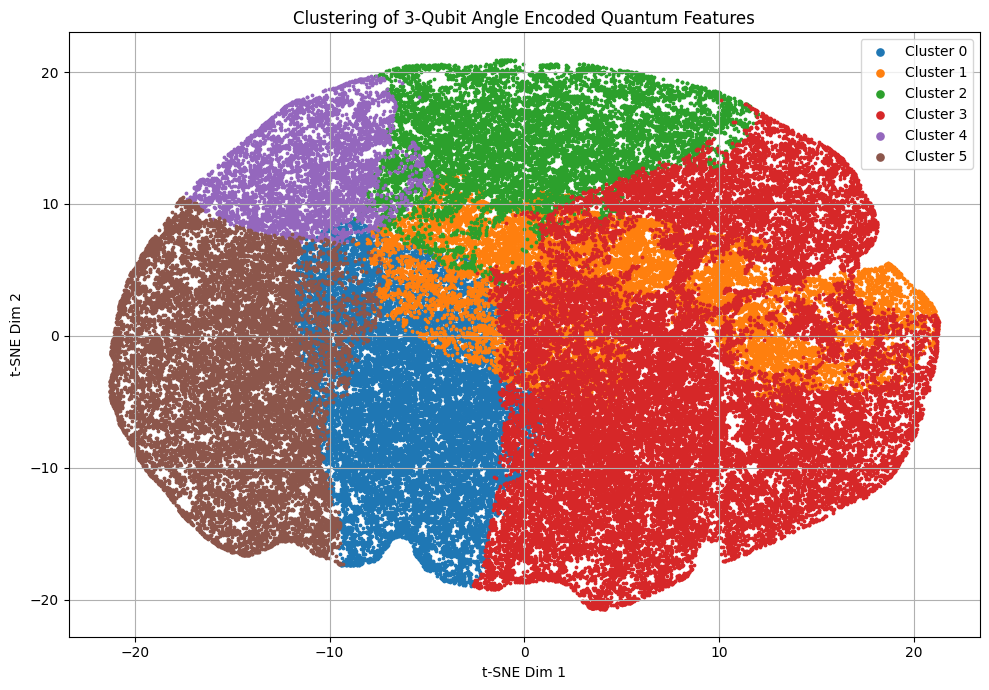

In [ ]:
quantum_real = np.real(encoded_states)
quantum_imag = np.imag(encoded_states)
quantum_full = np.hstack((quantum_real, quantum_imag))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(quantum_full)

#  KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(X_scaled)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=500, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = X_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=3, label=f'Cluster {i}')

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Clustering of 3-Qubit Angle Encoded Quantum Features")
plt.legend(markerscale=3)
plt.grid(True)
plt.tight_layout()
plt.show()

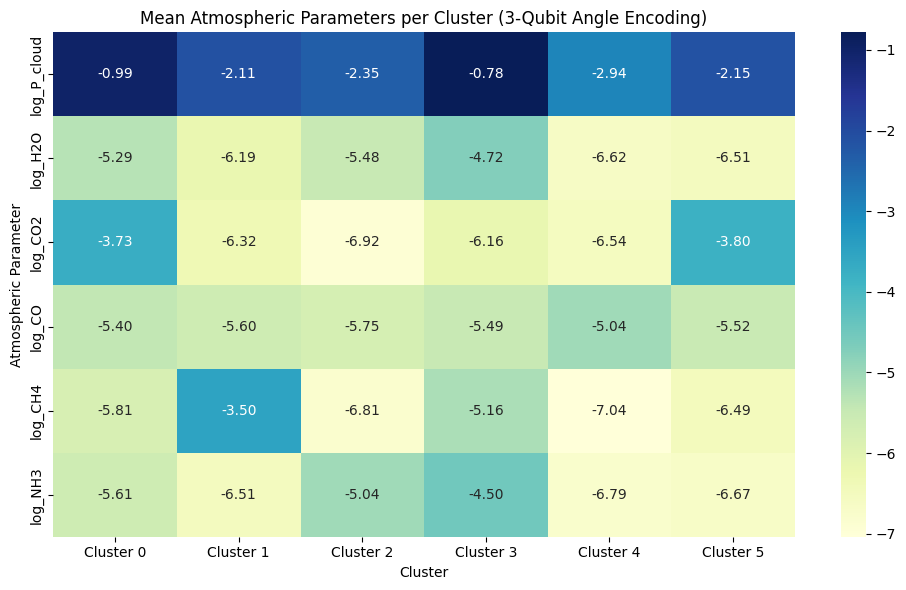

In [ ]:
X_params = df.iloc[:, 8:14].values.astype(float)
params_df = pd.DataFrame(X_params, columns=selected_params)
params_df['cluster'] = labels

cluster_means = params_df.groupby('cluster')[selected_params].mean()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=[f'Cluster {i}' for i in cluster_means.index],
            yticklabels=selected_params)

plt.title("Mean Atmospheric Parameters per Cluster (3-Qubit Angle Encoding)")
plt.xlabel("Cluster")
plt.ylabel("Atmospheric Parameter")
plt.tight_layout()
plt.show()

# Amplitude Encoding With 3 Qubits

In [ ]:
# Ampitude Encoding

norms = np.linalg.norm(X_autoenc, axis=1, keepdims=True)
X_amp_normalized = X_autoenc / norms

# Quantum device with 3 qubits
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Amplitude embedding
@qml.qnode(dev)
def amplitude_encode(x):
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=False)
    return qml.state()

# Encode all samples
encoded_states = []
N = X_amp_normalized.shape[0]
for i in range(N):
    state = amplitude_encode(X_amp_normalized[i])
    encoded_states.append(state)

encoded_states = np.array(encoded_states)
print("Encoded quantum states shape (amp):", encoded_states.shape)


Encoded quantum states shape (amp): (98664, 8)


In [ ]:
quantum_real = np.real(encoded_states)
quantum_imag = np.imag(encoded_states)

# Concatenate for clustering
quantum_full = np.hstack([quantum_real, quantum_imag])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


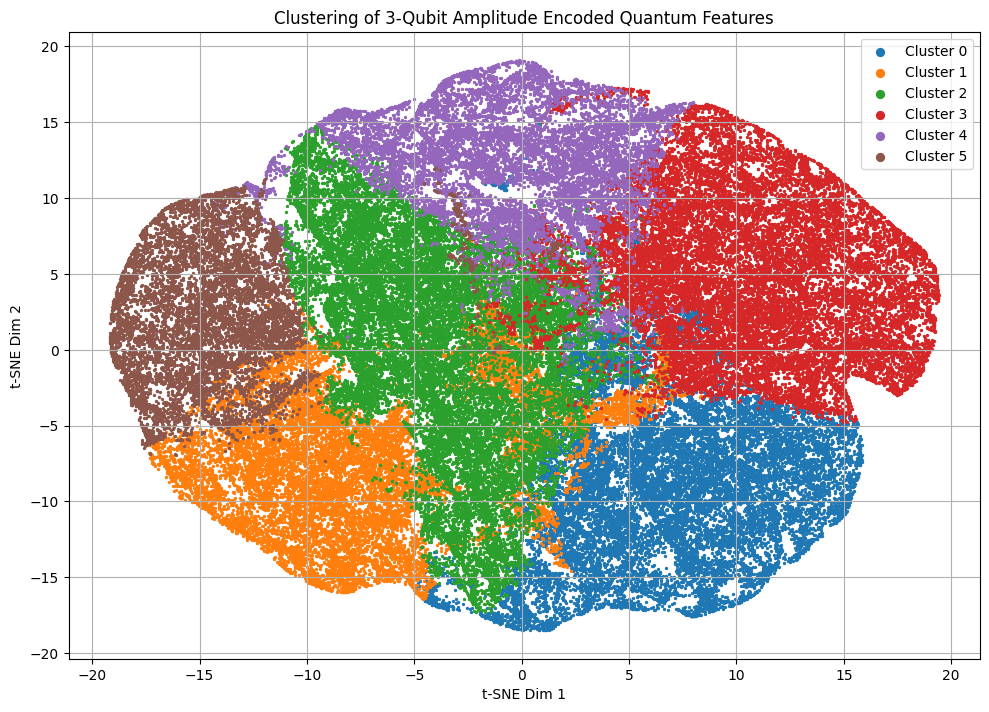

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(quantum_full)

# KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(X_scaled)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0, n_iter=500)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE with cluster labels
plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = X_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)
plt.grid(True)
plt.tight_layout()
plt.title("Clustering of 3-Qubit Amplitude Encoded Quantum Features")
plt.show()

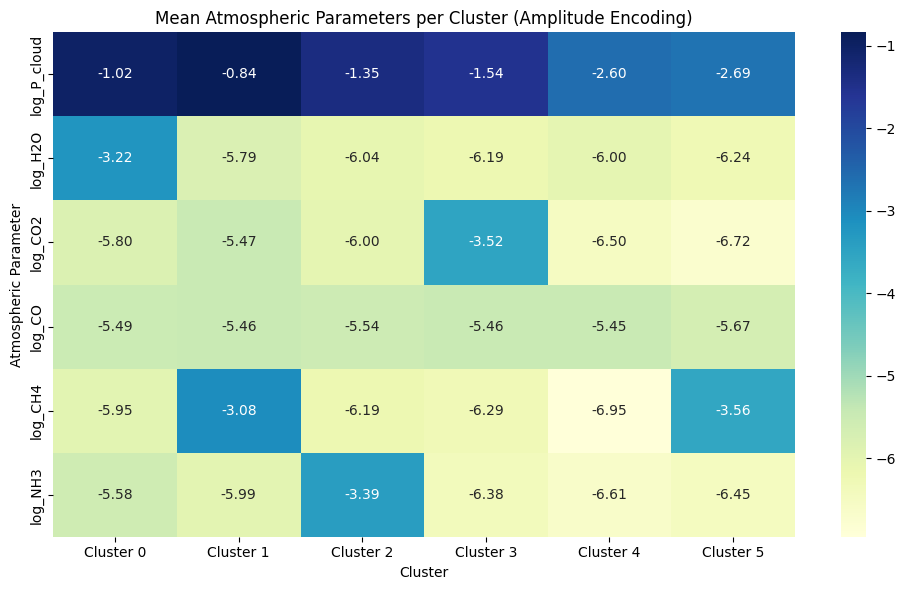

In [ ]:

# Create parameter DataFrame
params_df = pd.DataFrame(params, columns=selected_params)
params_df['cluster'] = labels

# Compute mean per cluster
cluster_means = params_df.groupby('cluster')[selected_params].mean()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=[f'Cluster {i}' for i in cluster_means.index],
            yticklabels=selected_params)

plt.title("Mean Atmospheric Parameters per Cluster (Amplitude Encoding)")
plt.xlabel("Cluster")
plt.ylabel("Atmospheric Parameter")
plt.tight_layout()
plt.show()

# Amplitude Encoding with 4 Qubits

In [ ]:
X_amp_padded = np.hstack([X_autoenc, np.zeros((X_autoenc.shape[0], 8))])

# Normalize each vector
norms_4q = np.linalg.norm(X_amp_padded, axis=1, keepdims=True)
X_amp_normalized_4q = X_amp_padded / norms_4q

# 4-qubit quantum device
n_qubits_4q = 4
dev_4q = qml.device("default.qubit", wires=n_qubits_4q)

@qml.qnode(dev_4q)
def amplitude_encode_4q(x):
    qml.AmplitudeEmbedding(x, wires=range(n_qubits_4q), normalize=False)
    return qml.state()

# Encode all samples
encoded_states_4q = []
for i in range(X_amp_normalized_4q.shape[0]):
    state = amplitude_encode_4q(X_amp_normalized_4q[i])
    encoded_states_4q.append(state)

encoded_states_4q = np.array(encoded_states_4q)
print("Encoded quantum states shape (4q amp):", encoded_states_4q.shape)



Encoded quantum states shape (4q amp): (98664, 16)


In [ ]:
# Prepare for clustering
quantum_real_4q = np.real(encoded_states_4q)
quantum_imag_4q = np.imag(encoded_states_4q)
quantum_full_4q = np.hstack([quantum_real_4q, quantum_imag_4q])

scaler_4q = StandardScaler()
X_scaled_4q = scaler_4q.fit_transform(quantum_full_4q)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


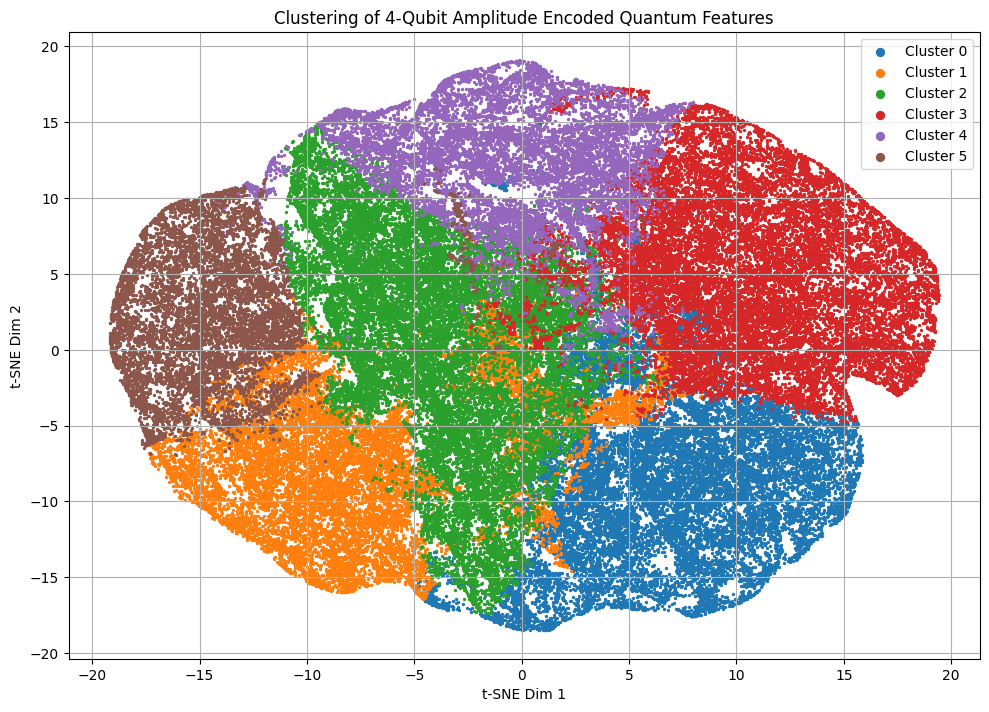

In [ ]:
kmeans_4q = KMeans(n_clusters=6, random_state=0)
labels_4q = kmeans_4q.fit_predict(X_scaled_4q)

# t-SNE
tsne_4q = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0, n_iter=500)
X_tsne_4q = tsne_4q.fit_transform(X_scaled_4q)

# Plot
plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = X_tsne_4q[labels_4q == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)
plt.grid(True)
plt.tight_layout()
plt.title("Clustering of 4-Qubit Amplitude Encoded Quantum Features")
plt.show()

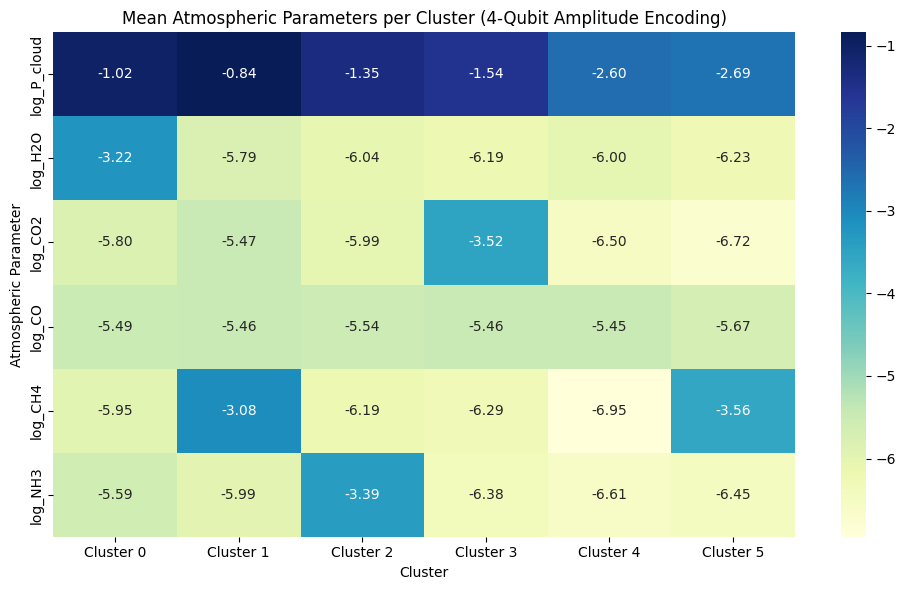

In [ ]:
selected_params = ['log_P_cloud', 'log_H2O', 'log_CO2',
                   'log_CO', 'log_CH4', 'log_NH3']
params = df.iloc[:, 8:14].values.astype(float)

params_df_4q = pd.DataFrame(params, columns=selected_params)
params_df_4q['cluster'] = labels_4q

cluster_means_4q = params_df_4q.groupby('cluster')[selected_params].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_4q.T, annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=[f'Cluster {i}' for i in cluster_means_4q.index],
            yticklabels=selected_params)

plt.title("Mean Atmospheric Parameters per Cluster (4-Qubit Amplitude Encoding)")
plt.xlabel("Cluster")
plt.ylabel("Atmospheric Parameter")
plt.tight_layout()
plt.show()

**There was no significant difference observed in the performance when using amplitude encoding with 4 qubits instead of 3**

# **QSample Encoding**

In [ ]:
from sklearn.decomposition import PCA
from scipy.special import softmax

X_params = df.iloc[:, 8:14].values.astype(float)
X_autoenc = df.iloc[:, :8].values.astype(float)

if X_autoenc.shape[1] != 8:
    pca = PCA(n_components=8)
    X_autoenc = pca.fit_transform(X_autoenc)

X_probs = softmax(X_autoenc, axis=1)
X_amplitudes = np.sqrt(X_probs)
X_amplitudes /= np.linalg.norm(X_amplitudes, axis=1, keepdims=True)

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qsample_encode(amplitudes):
    qml.MottonenStatePreparation(amplitudes, wires=range(n_qubits))
    return qml.state()

encoded_states = []
for amp in X_amplitudes:
    state = qsample_encode(amp)
    encoded_states.append(state)

encoded_states = np.array(encoded_states)
print("Encoded quantum states shape:", encoded_states.shape)


Encoded quantum states shape: (98664, 8)


In [ ]:
quantum_real = np.real(encoded_states)
quantum_imag = np.imag(encoded_states)
quantum_full = quantum_real

In [ ]:
print("Any NaNs?", np.isnan(quantum_full).any())
print("Any Infs?", np.isinf(quantum_full).any())
print("Variance per column:", np.var(quantum_full, axis=0))

Any NaNs? False
Any Infs? False
Variance per column: [0.05644708 0.00081299 0.00060581 0.08301284 0.06426899 0.00166849
 0.02211048 0.00313843]


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


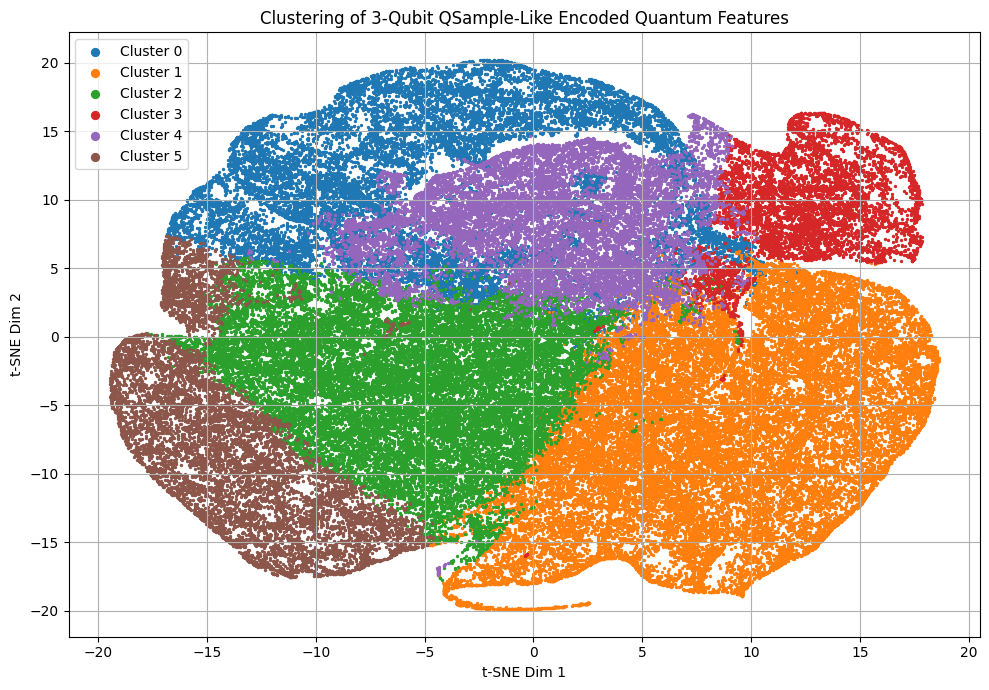

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(quantum_full)

kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(X_scaled)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=500, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = X_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)
plt.grid(True)
plt.title("Clustering of 3-Qubit QSample-Like Encoded Quantum Features")
plt.tight_layout()
plt.show()

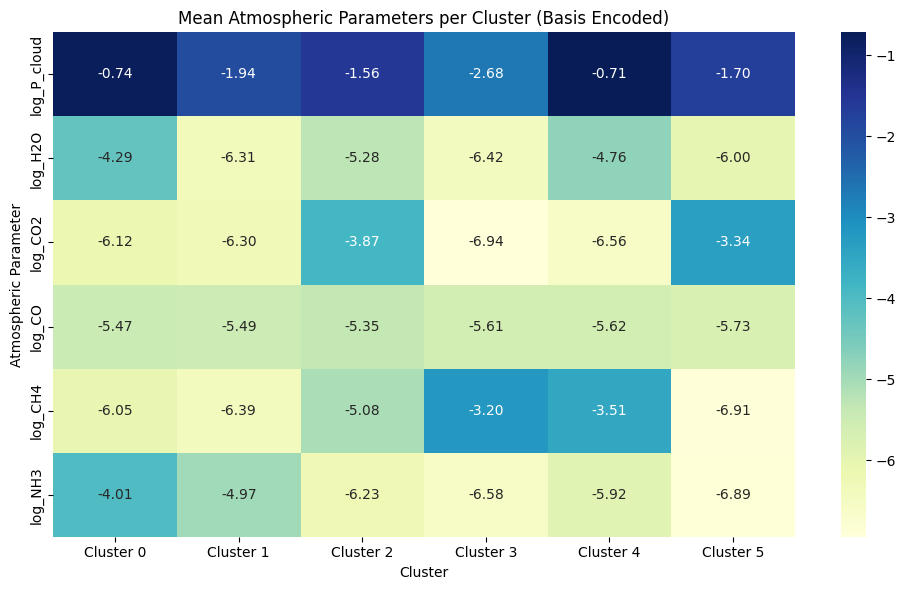

In [ ]:
params_df = pd.DataFrame(X_params, columns=selected_params)
params_df['cluster'] = labels

cluster_means = params_df.groupby('cluster')[selected_params].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=[f'Cluster {i}' for i in cluster_means.index],
            yticklabels=selected_params)

plt.title("Mean Atmospheric Parameters per Cluster (Basis Encoded)")
plt.xlabel("Cluster")
plt.ylabel("Atmospheric Parameter")
plt.tight_layout()
plt.show()